In [1]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, BatchNormalization, Dense, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

2024-07-08 22:11:27.071038: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 22:11:27.071138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 22:11:27.186673: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
folder_benign_train = '/kaggle/input/skin-cancer-malignant-vs-benign/train/benign'
folder_malignant_train = '/kaggle/input/skin-cancer-malignant-vs-benign/train/malignant'

folder_benign_test = '/kaggle/input/skin-cancer-malignant-vs-benign/test/benign'
folder_malignant_test = '/kaggle/input/skin-cancer-malignant-vs-benign/test/malignant'
# Helper function to read images
def read_image(imname):
    img = Image.open(imname).resize((224, 224))  # Resize to match DenseNet201 input size
    return np.asarray(img)

# Load training images
ims_benign = [read_image(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='float32')
ims_malignant = [read_image(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='float32')

# Load testing images
ims_benign_test = [read_image(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign_test, dtype='float32')
ims_malignant_test = [read_image(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant_test, dtype='float32')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

# Merge data
X_train = np.concatenate((X_benign, X_malignant), axis=0)
y_train = np.concatenate((y_benign, y_malignant), axis=0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis=0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis=0)

# Shuffle data
train_indices = np.arange(X_train.shape[0])
np.random.shuffle(train_indices)
X_train = X_train[train_indices]
y_train = y_train[train_indices]

test_indices = np.arange(X_test.shape[0])
np.random.shuffle(test_indices)
X_test = X_test[test_indices]
y_test = y_test[test_indices]


In [3]:
# Normalize the images
X_train /= 255.0
X_test /= 255.0


In [4]:
# Convert labels to categorical
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [5]:
# Define the data augmentation generator
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Use the generator for training data
train_generator = train_datagen.flow(X_train, y_train, batch_size=64)


In [6]:
# Load the DenseNet201 model without the top layers
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add new layers after the fourth dense block
x = base_model.output
x = Conv2D(128, (3, 1), padding='same', activation='relu')(x)
x = Conv2D(128, (1, 3), padding='same', activation='relu')(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
output = Dense(2, activation='softmax')(x)

# Combine base model and new layers
model = Model(inputs=base_model.input, outputs=output)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [7]:
# Create an instance of the Adam optimizer with a specified learning rate
optimizer = Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary to check the structure
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 19,191,810 (73.21 MB)

 Trainable params: 18,962,370 (72.34 MB)

 Non-trainable params: 229,440 (896.25 KB)

In [13]:
# Train the model with data augmentation and validate using test data
history = model.fit(train_generator, validation_data=(X_test, y_test),
                    epochs=25, verbose=1)

Epoch 1/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9149 - loss: 0.2095 - val_accuracy: 0.8000 - val_loss: 0.3997
Epoch 2/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9192 - loss: 0.2122 - val_accuracy: 0.8652 - val_loss: 0.2892
Epoch 3/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9379 - loss: 0.1693 - val_accuracy: 0.8409 - val_loss: 0.3320
Epoch 4/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9555 - loss: 0.1263 - val_accuracy: 0.8864 - val_loss: 0.2623
Epoch 5/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9496 - loss: 0.1400 - val_accuracy: 0.9030 - val_loss: 0.2609
Epoch 6/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9689 - loss: 0.1084 - val_accuracy: 0.8879 - val_loss: 0.2939
Epoch 7/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9809 - loss: 0.0688 - val_accuracy: 0.8985 - val_loss: 0.2971
Epoch 8/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9717 - loss: 0.0898 - val_accuracy: 0.8818 - val_loss:

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


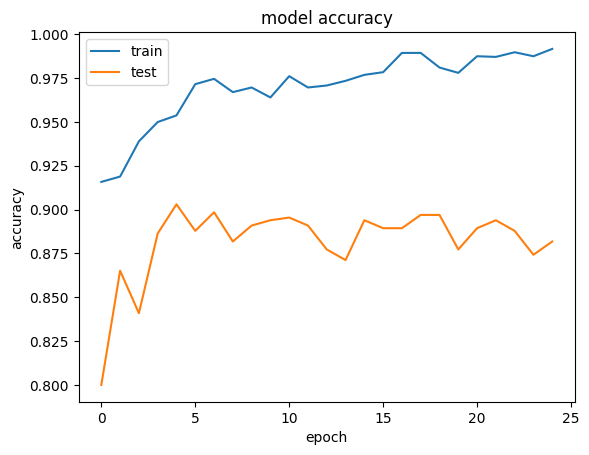

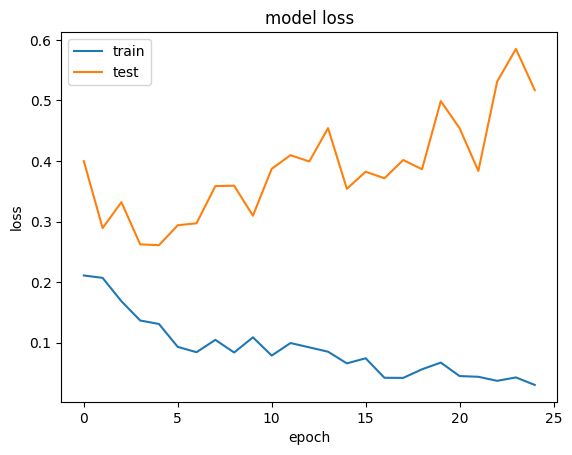

In [14]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [15]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.8731 - loss: 0.5561
Loss: 0.5169999599456787
Accuracy: 0.8818181753158569


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step


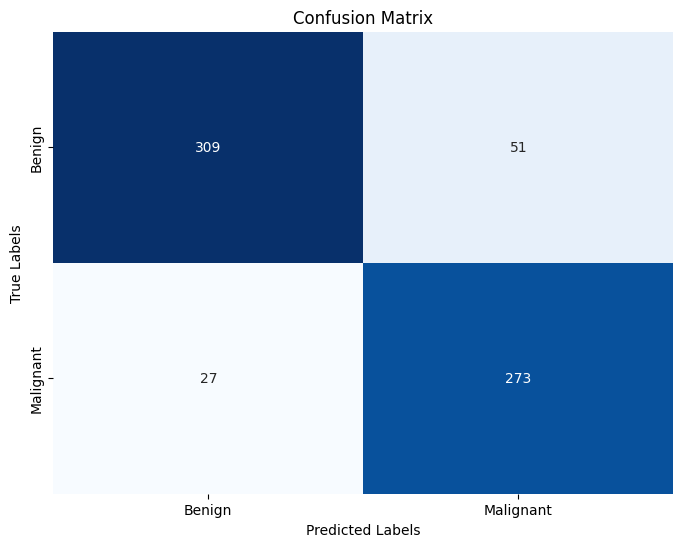

In [16]:
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=-1)
y_test_labels = np.argmax(y_test, axis=-1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [17]:
# Print classification report
print(classification_report(y_test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       360
           1       0.84      0.91      0.87       300

    accuracy                           0.88       660
   macro avg       0.88      0.88      0.88       660
weighted avg       0.88      0.88      0.88       660

